In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random, vmap
from jaxtyping import Array, Float32, UInt32
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
def generate_intermediate_counts(
    rng_key: UInt32[Array, "2"],
    n_series: int,
    t_max_train: int,
    t_max_test: int,
    a: float = 1.0,
) -> tuple[
    Float32[Array, "t_max_train n_series"], Float32[Array, "t_max_test n_series"]
]:
    rng_key, rng_subkey = random.split(rng_key)
    lambdas = random.gamma(rng_subkey, a=a, shape=(1, n_series))

    t_max = t_max_train + t_max_test
    rng_key, rng_subkey = random.split(rng_key)
    counts = random.poisson(rng_subkey, lam=lambdas, shape=(t_max, n_series))
    counts = counts.astype(jnp.float32)

    return counts[:t_max_train, :], counts[t_max_train:, :]

In [3]:
counts_train, counts_test = generate_intermediate_counts(
    rng_key, n_series=500, t_max_train=30, t_max_test=10, a=1.0
)

series_ids = jnp.arange(counts_train.shape[1])

print(f"counts_train.shape: {counts_train.shape}")
print(f"counts_test.shape: {counts_test.shape}")

counts_train.shape: (30, 500)
counts_test.shape: (10, 500)


In [4]:
t_train: Float32[Array, " t_max_train"] = jnp.arange(counts_train.shape[0])
t_test: Float32[Array, " "] = jnp.arange(
    counts_train.shape[0], counts_train.shape[0] + counts_test.shape[0]
)

In [5]:
t: Float32[Array, " t_max"] = jnp.concatenate([t_train, t_test])
counts: Float32[Array, "t_max n_series"] = jnp.concatenate([counts_train, counts_test])

assert counts.shape == (t.shape[0], series_ids.shape[0])

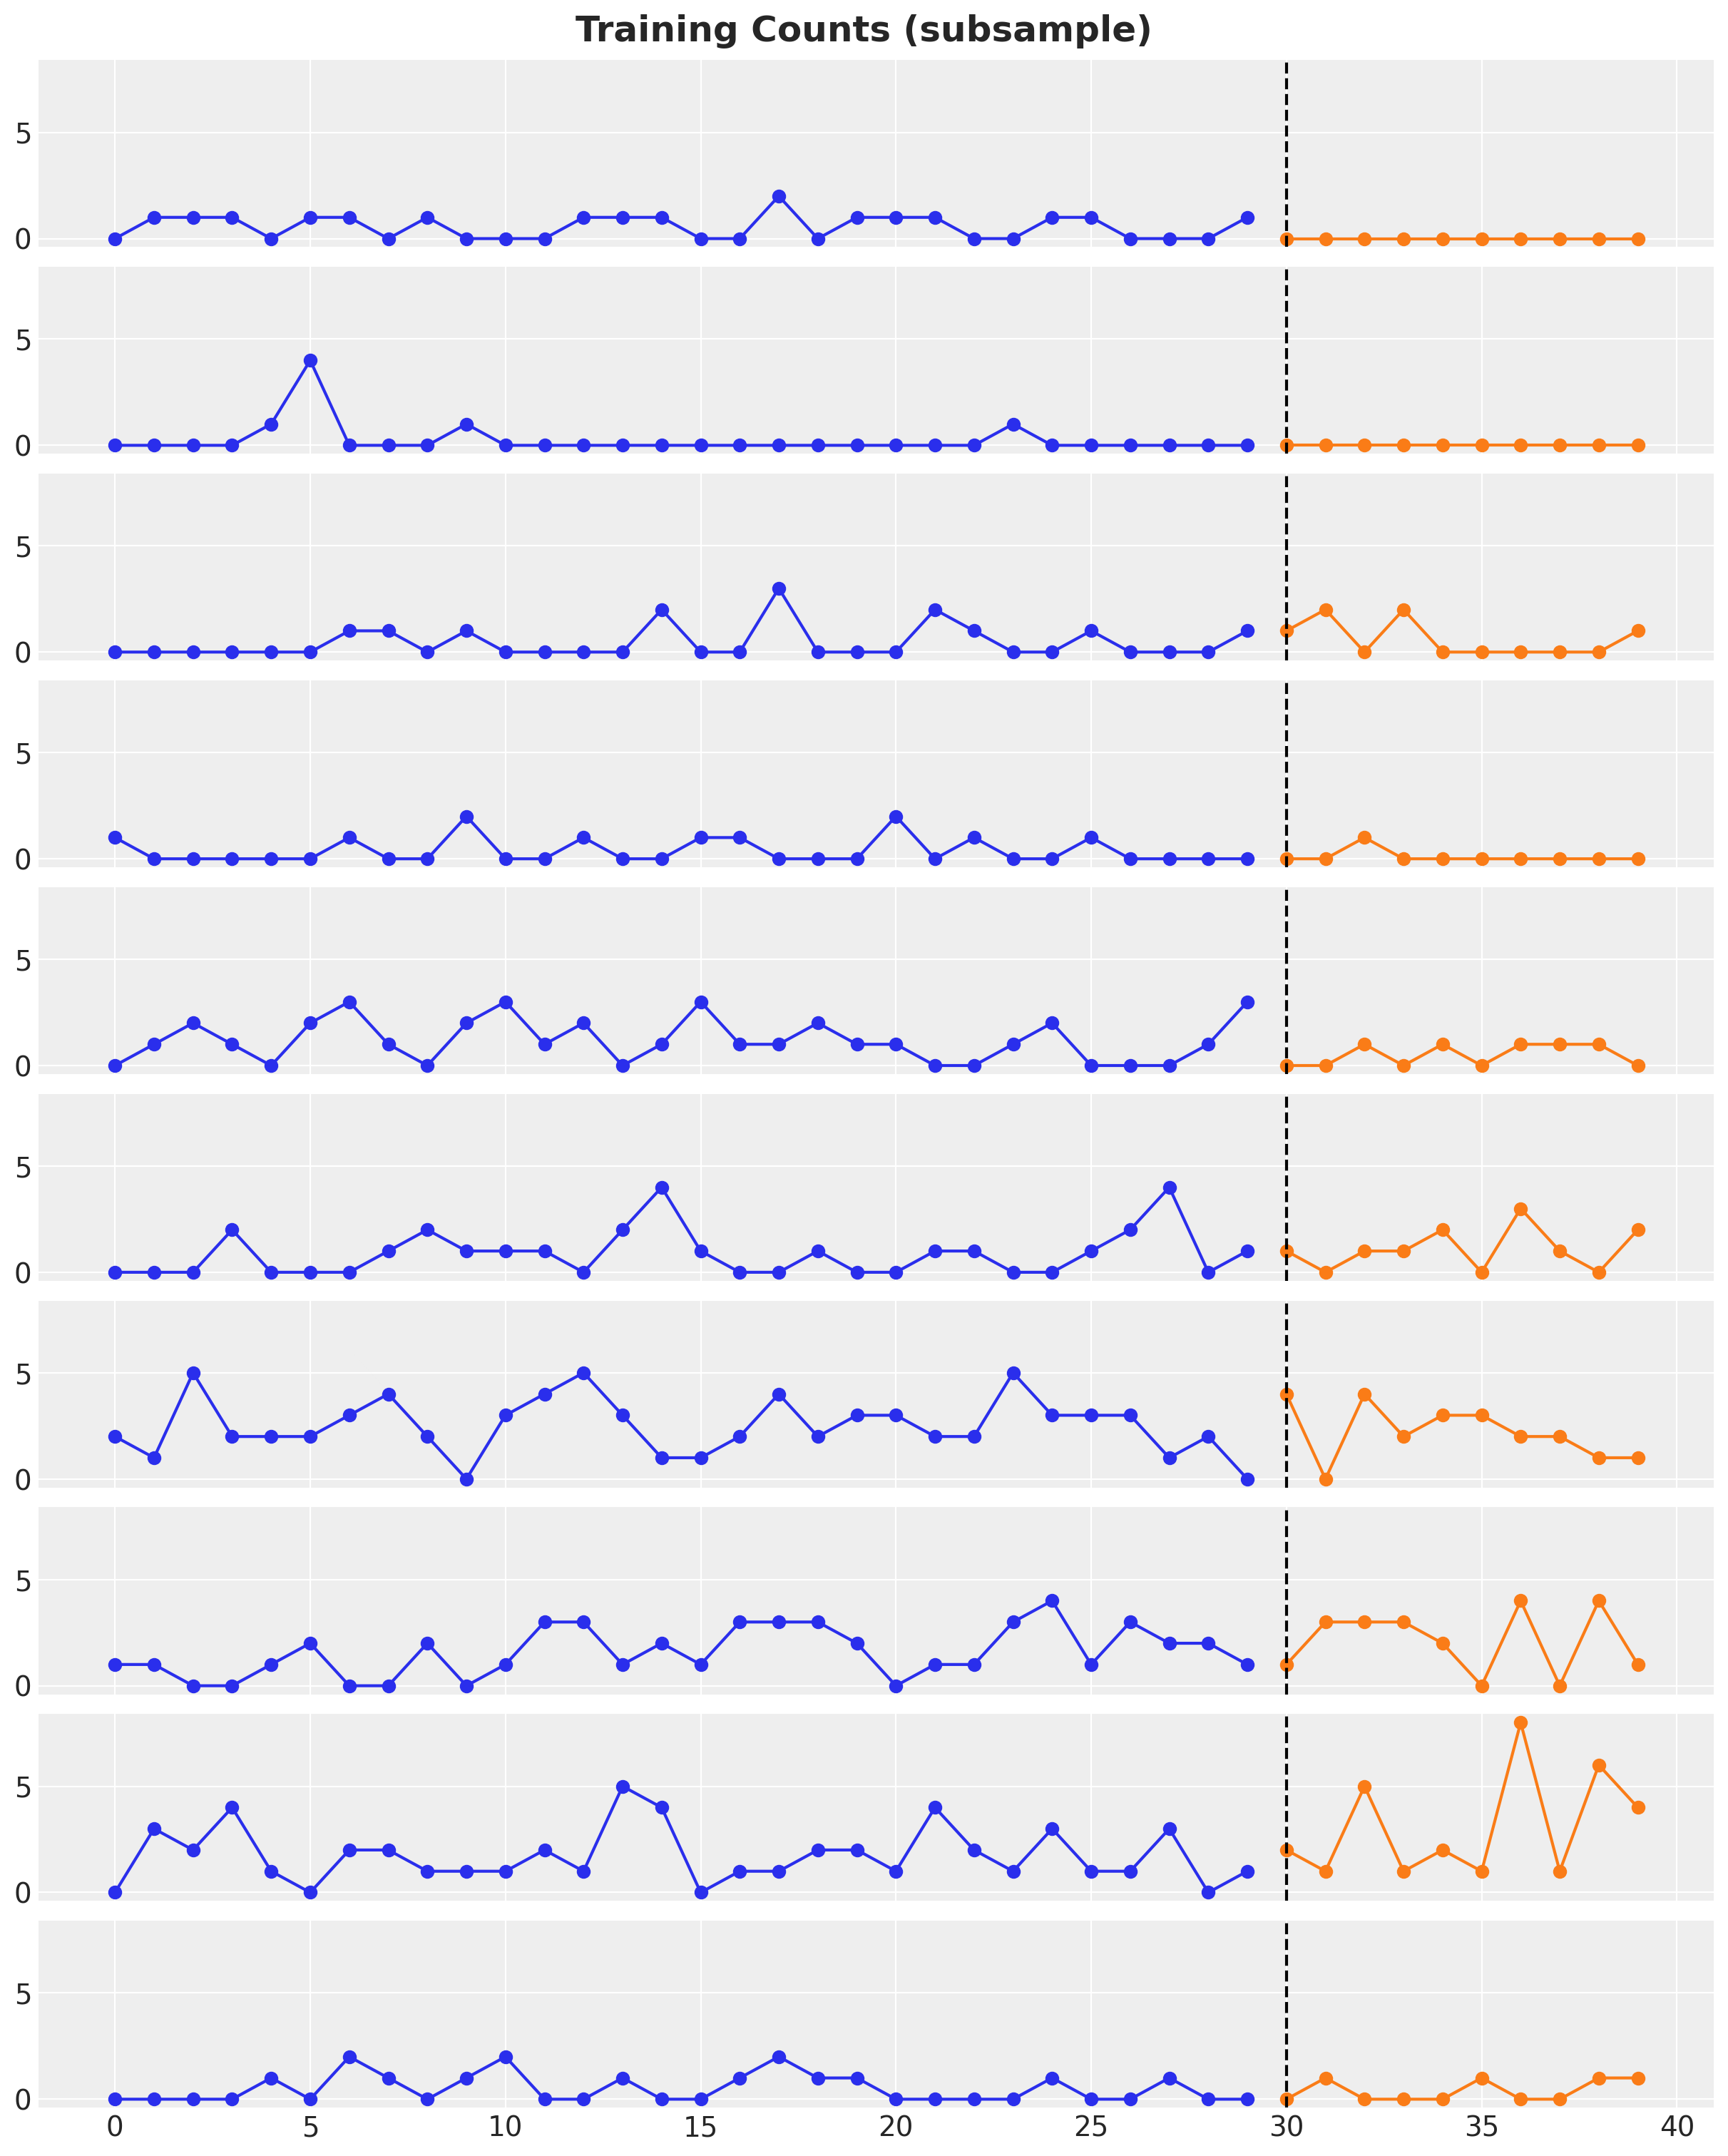

In [6]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax[i].plot(t_train, counts_train[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Training Counts (subsample)", fontsize=18, fontweight="bold");

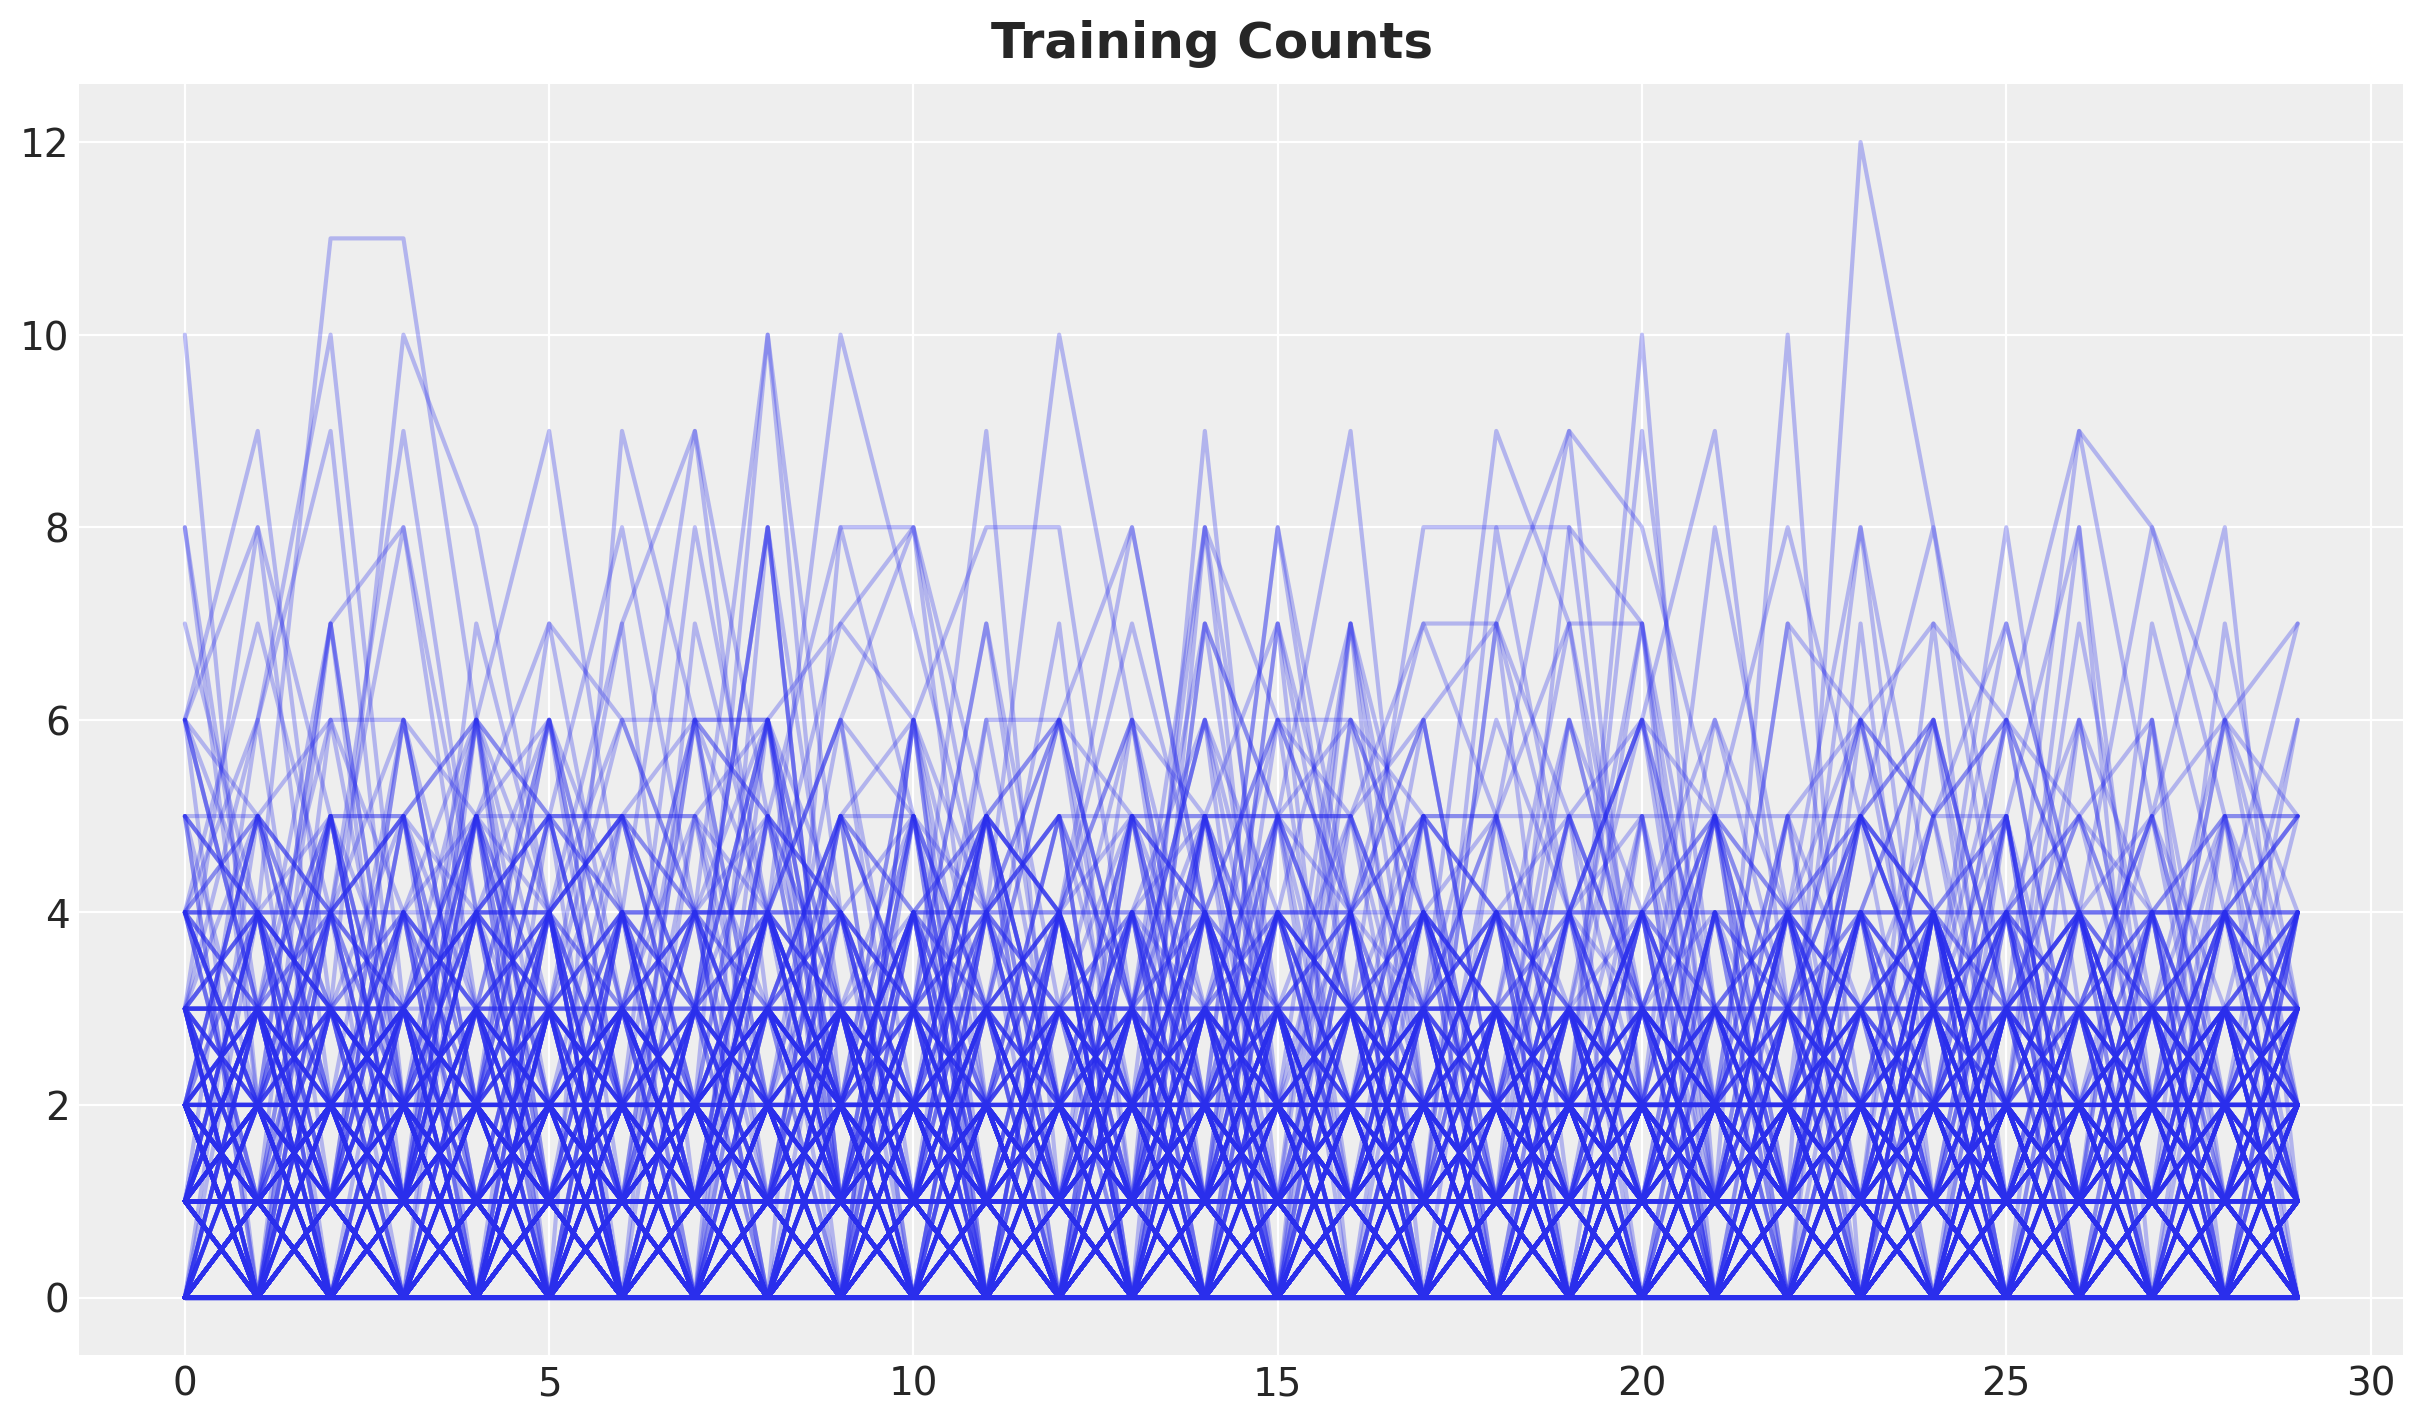

In [7]:
fig, ax = plt.subplots()
ax.plot(t_train, counts_train, c="C0", alpha=0.3)
fig.suptitle("Training Counts", fontsize=18, fontweight="bold");

In [8]:
def replace_leading_zeros_with_nans(x: Float32[Array, " t"]) -> Float32[Array, " t"]:
    # Find first non-zero element
    first_nonzero = jnp.argmax(x != 0)

    # Create mask that is True for leading zeros
    leading_zeros_mask = jnp.arange(x.shape[0]) < first_nonzero

    # Replace leading zeros with NaNs
    return jnp.where(leading_zeros_mask, jnp.nan, x)


x = jnp.array([0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 0.0, 0.0, 0.0])

replace_leading_zeros_with_nans(x)

Array([nan, nan, nan,  1.,  2.,  3.,  0.,  0.,  0.], dtype=float32)

In [9]:
counts_train_masked = vmap(replace_leading_zeros_with_nans, in_axes=(1,), out_axes=1)(
    counts_train
)

assert counts_train_masked.shape == counts_train.shape

assert jnp.allclose(
    jnp.where(jnp.isnan(counts_train_masked), 0.0, counts_train_masked), counts_train
)

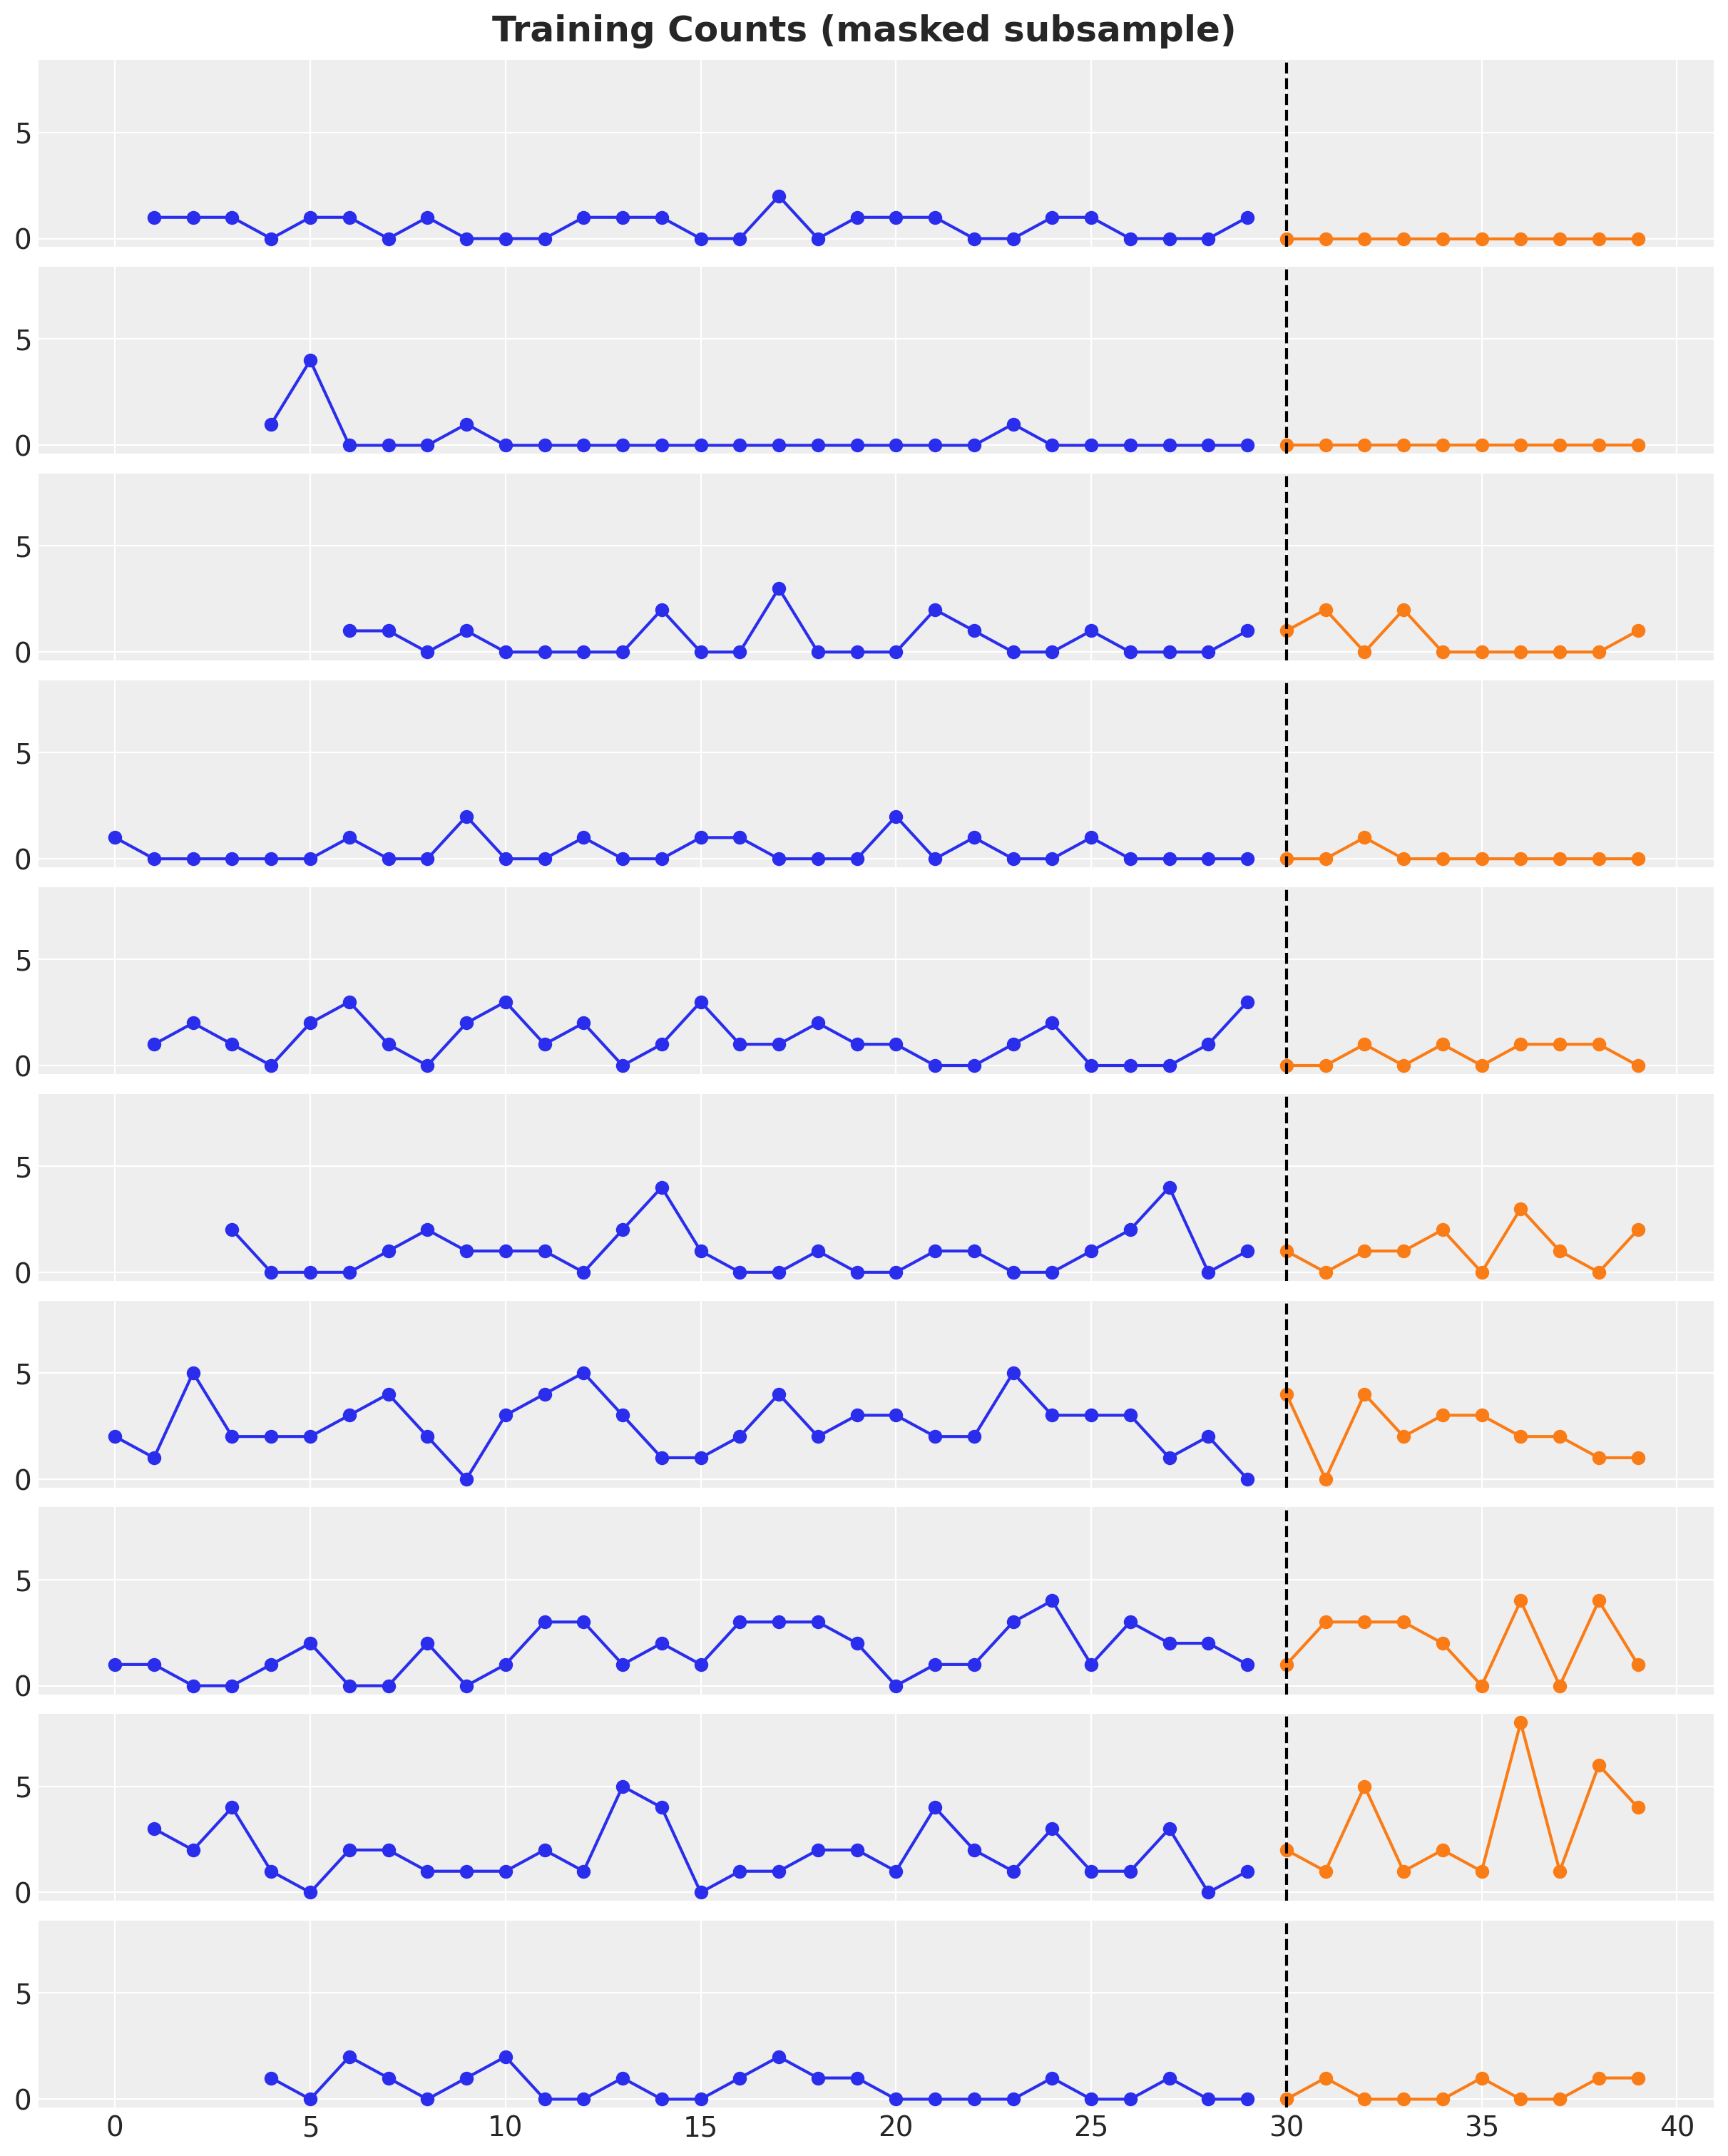

In [10]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    ax[i].plot(t_train, counts_train_masked[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Training Counts (masked subsample)", fontsize=18, fontweight="bold");

In [26]:
def model(
    counts_masked: Float32[Array, "t_max n_series"], future: int = 0
) -> None | Float32[Array, "future n_series"]:
    t_max, n_series = counts_masked.shape

    # def model(counts_masked, future=0) -> None:
    t_max, n_series = counts_masked.shape
    with numpyro.plate("n_series", n_series):
        z_smoothing = numpyro.sample(
            "z_smoothing", dist.Beta(concentration1=10, concentration0=40)
        )
        p_smoothing = numpyro.sample(
            "p_smoothing", dist.Beta(concentration1=10, concentration0=40)
        )
        noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max,
            jnp.where(
                counts_masked[t] > 0,
                z_smoothing * counts_masked[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max,
            jnp.where(
                counts_masked[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - p_smoothing) * p_prev,
            ),
            p_prev,
        )

        mu = z_next * p_next
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return (z_next, p_next), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": counts_masked}):
        _, preds = scan(
            transition_fn,
            (counts_masked[0], 0.5 * jnp.ones_like(counts_masked[0])),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("forecast", preds[-future:])
    return None

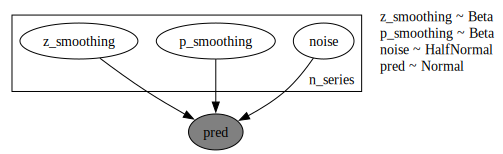

In [27]:
numpyro.render_model(
    model=model,
    model_kwargs={"counts_masked": counts_train_masked},
    render_distributions=True,
    render_params=True,
)

In [28]:
prior_predictive = Predictive(model=model, num_samples=1_000, return_sites=["pred"])

rng_key, rng_subkey = random.split(rng_key)
prior_predictive_samples = prior_predictive(rng_subkey, counts_train_masked)

prior_predictive_idata = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_predictive_samples.items()},
    coords={"t_max": t_train, "n_series": series_ids},
    dims={"pred": ["t_max", "n_series"]},
)

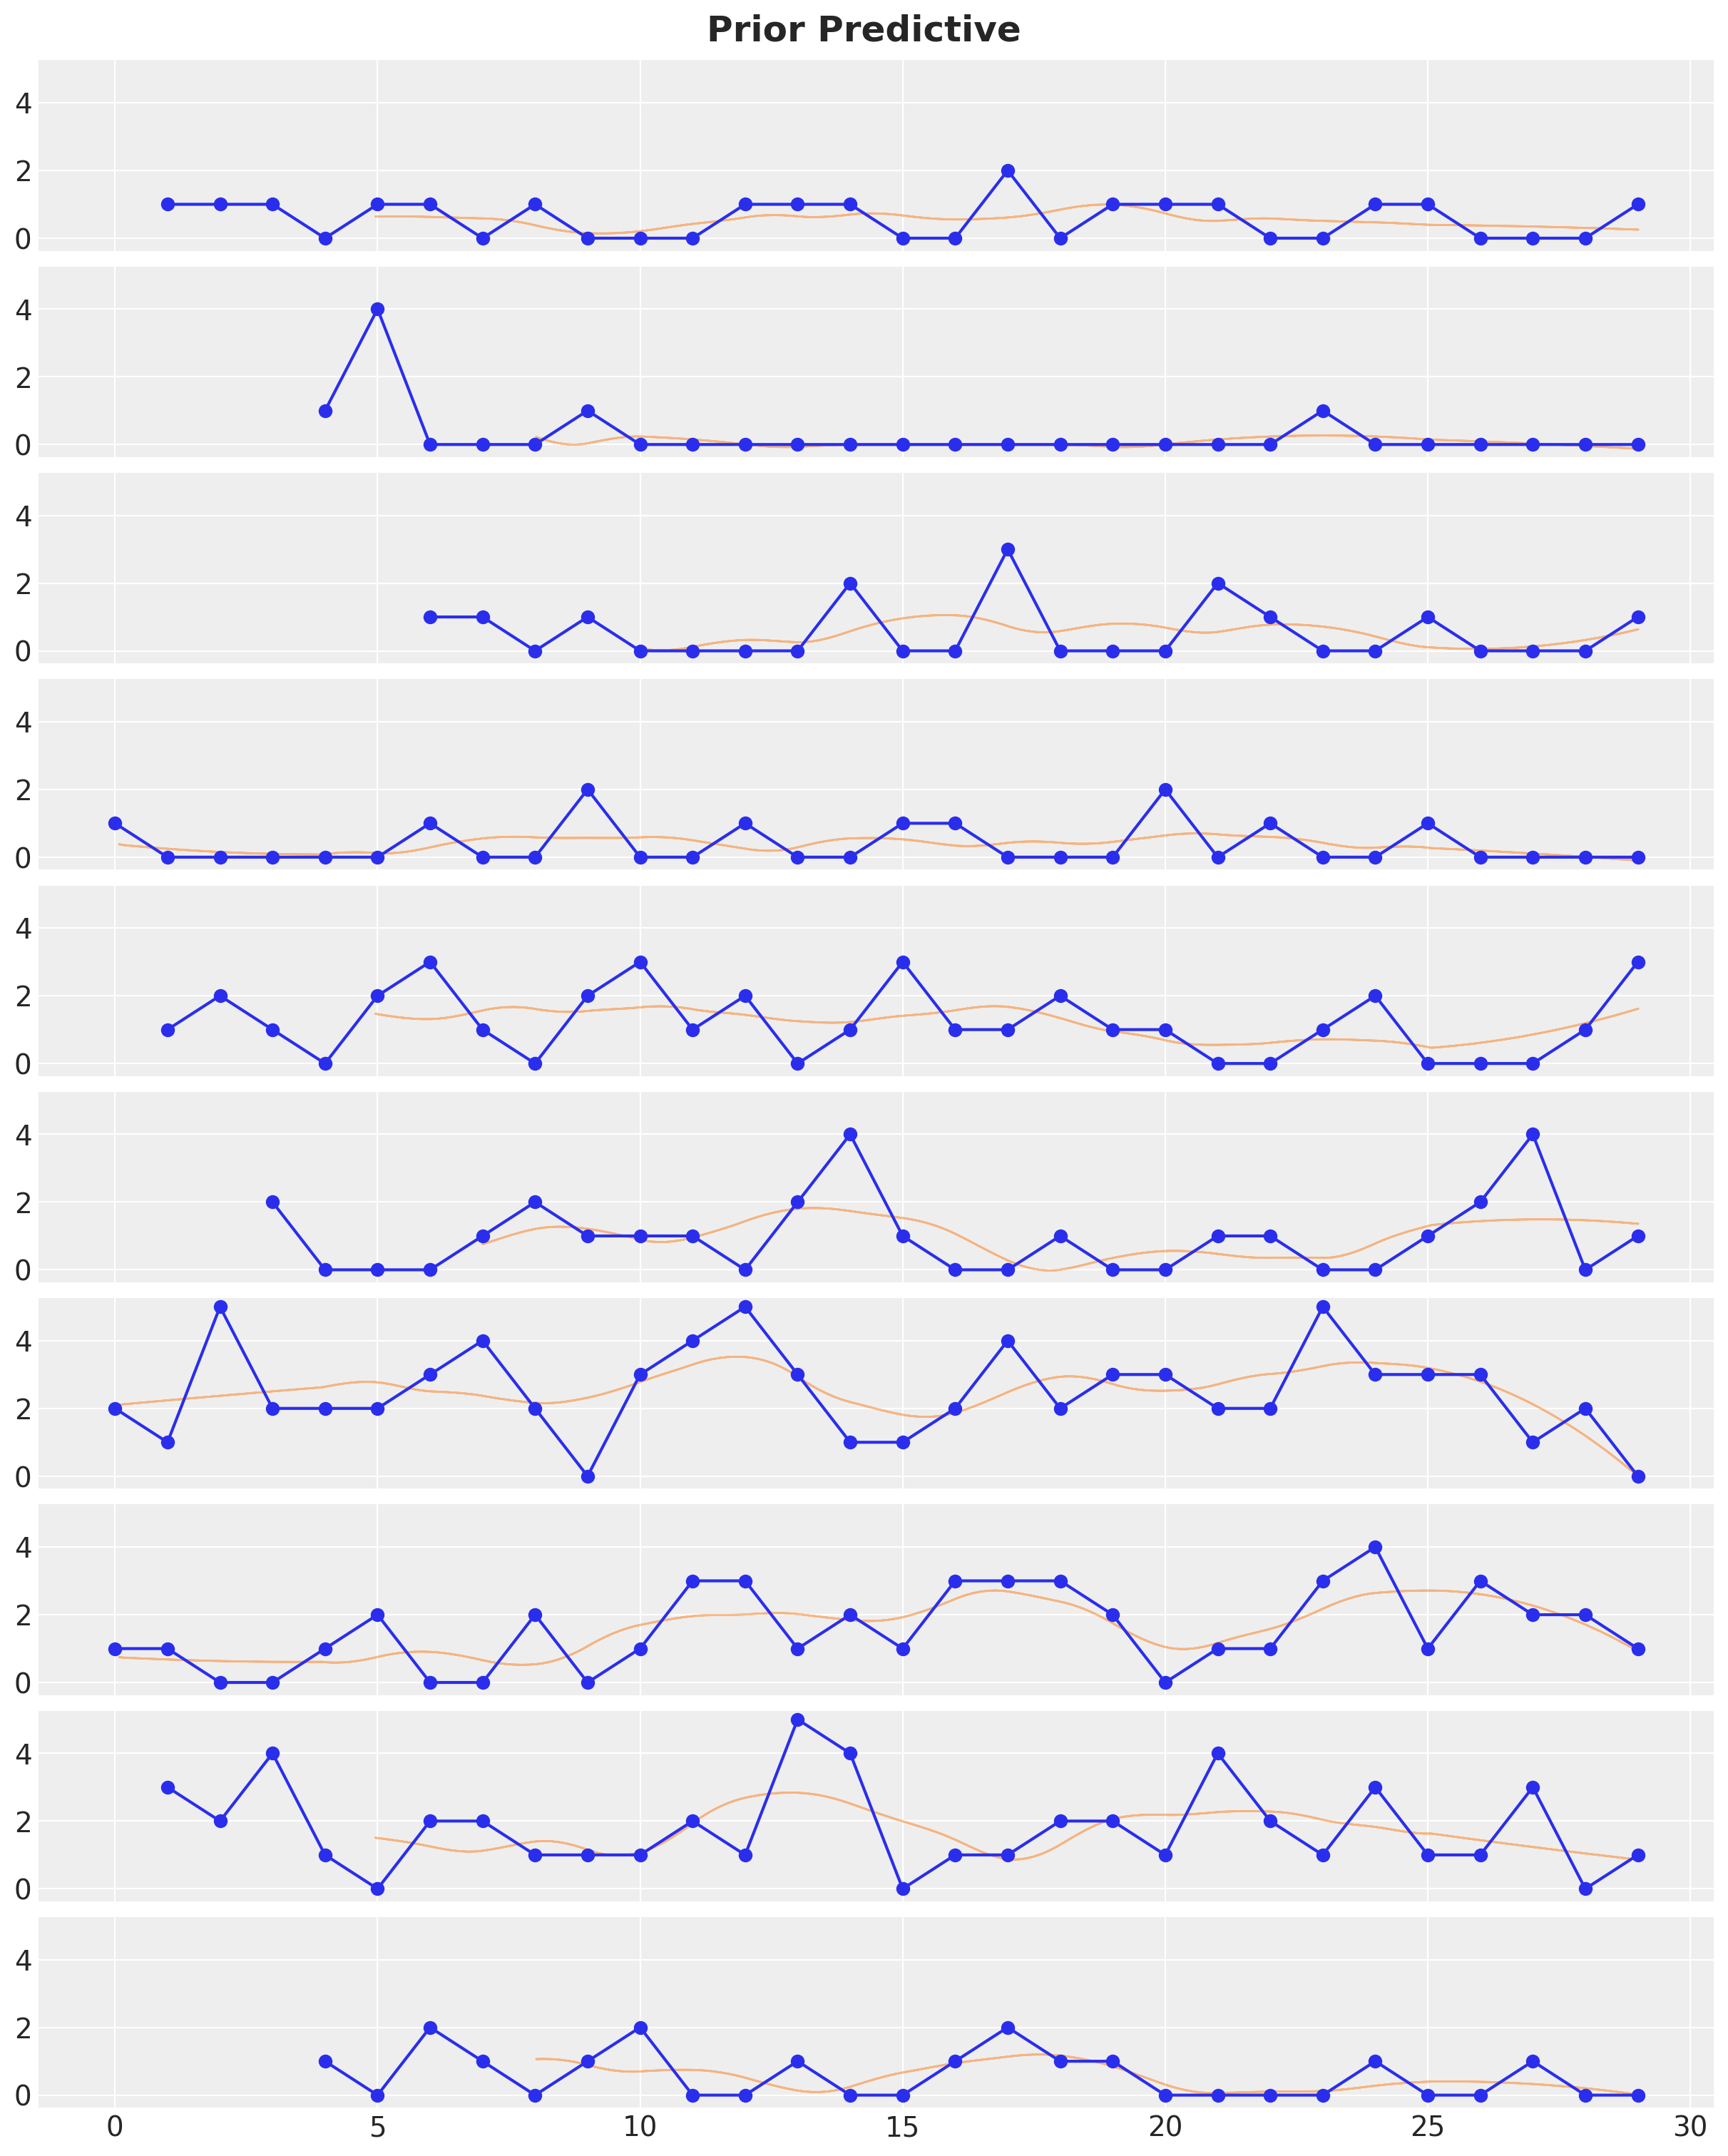

In [29]:
n_series_to_plot = 10

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    az.plot_hdi(
        t_train,
        prior_predictive_idata["prior_predictive"].sel(n_series=i)["pred"],
        hdi_prob=0.94,
        ax=ax[i],
    )

    ax[i].plot(t_train, counts_train_masked[:, i], marker="o", color="C0")

fig.suptitle("Prior Predictive", fontsize=18, fontweight="bold");

100%|██████████| 30000/30000 [00:08<00:00, 3654.60it/s, init loss: 63931.1797, avg. loss [28501-30000]: 4543.1051] 


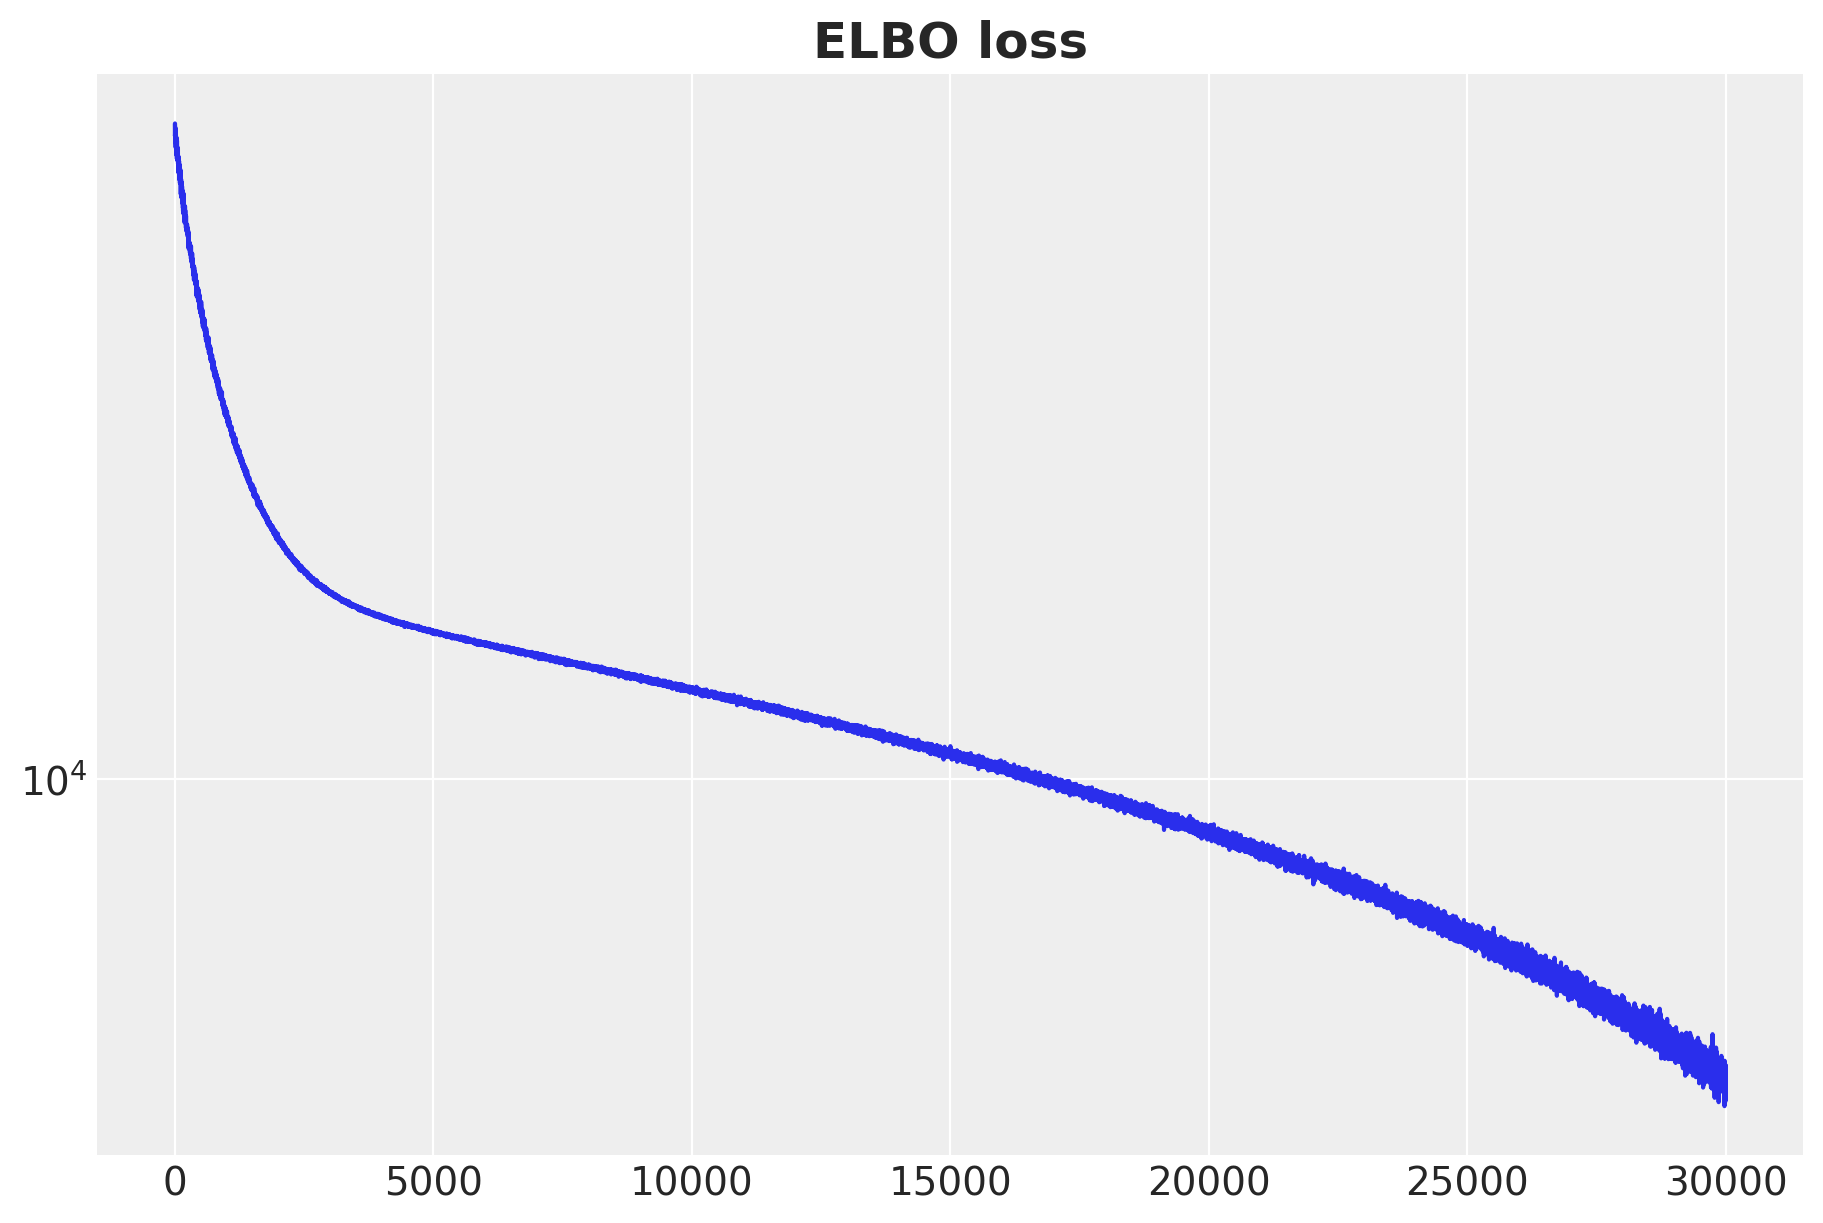

In [30]:
guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.001)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 30_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    counts_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_yscale("log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [31]:
posterior_predictive = Predictive(
    model=model, num_samples=1_000, return_sites=["forecast"]
)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, counts, future=t_test.shape[0]
)

posterior_predictive_idata = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior_predictive_samples.items()
    },
    coords={"t_max": t_test, "n_series": series_ids},
    dims={"forecast": ["t_max", "n_series"]},
)

In [32]:
posterior_predictive_idata

Inference data with groups:
	> posterior_predictive

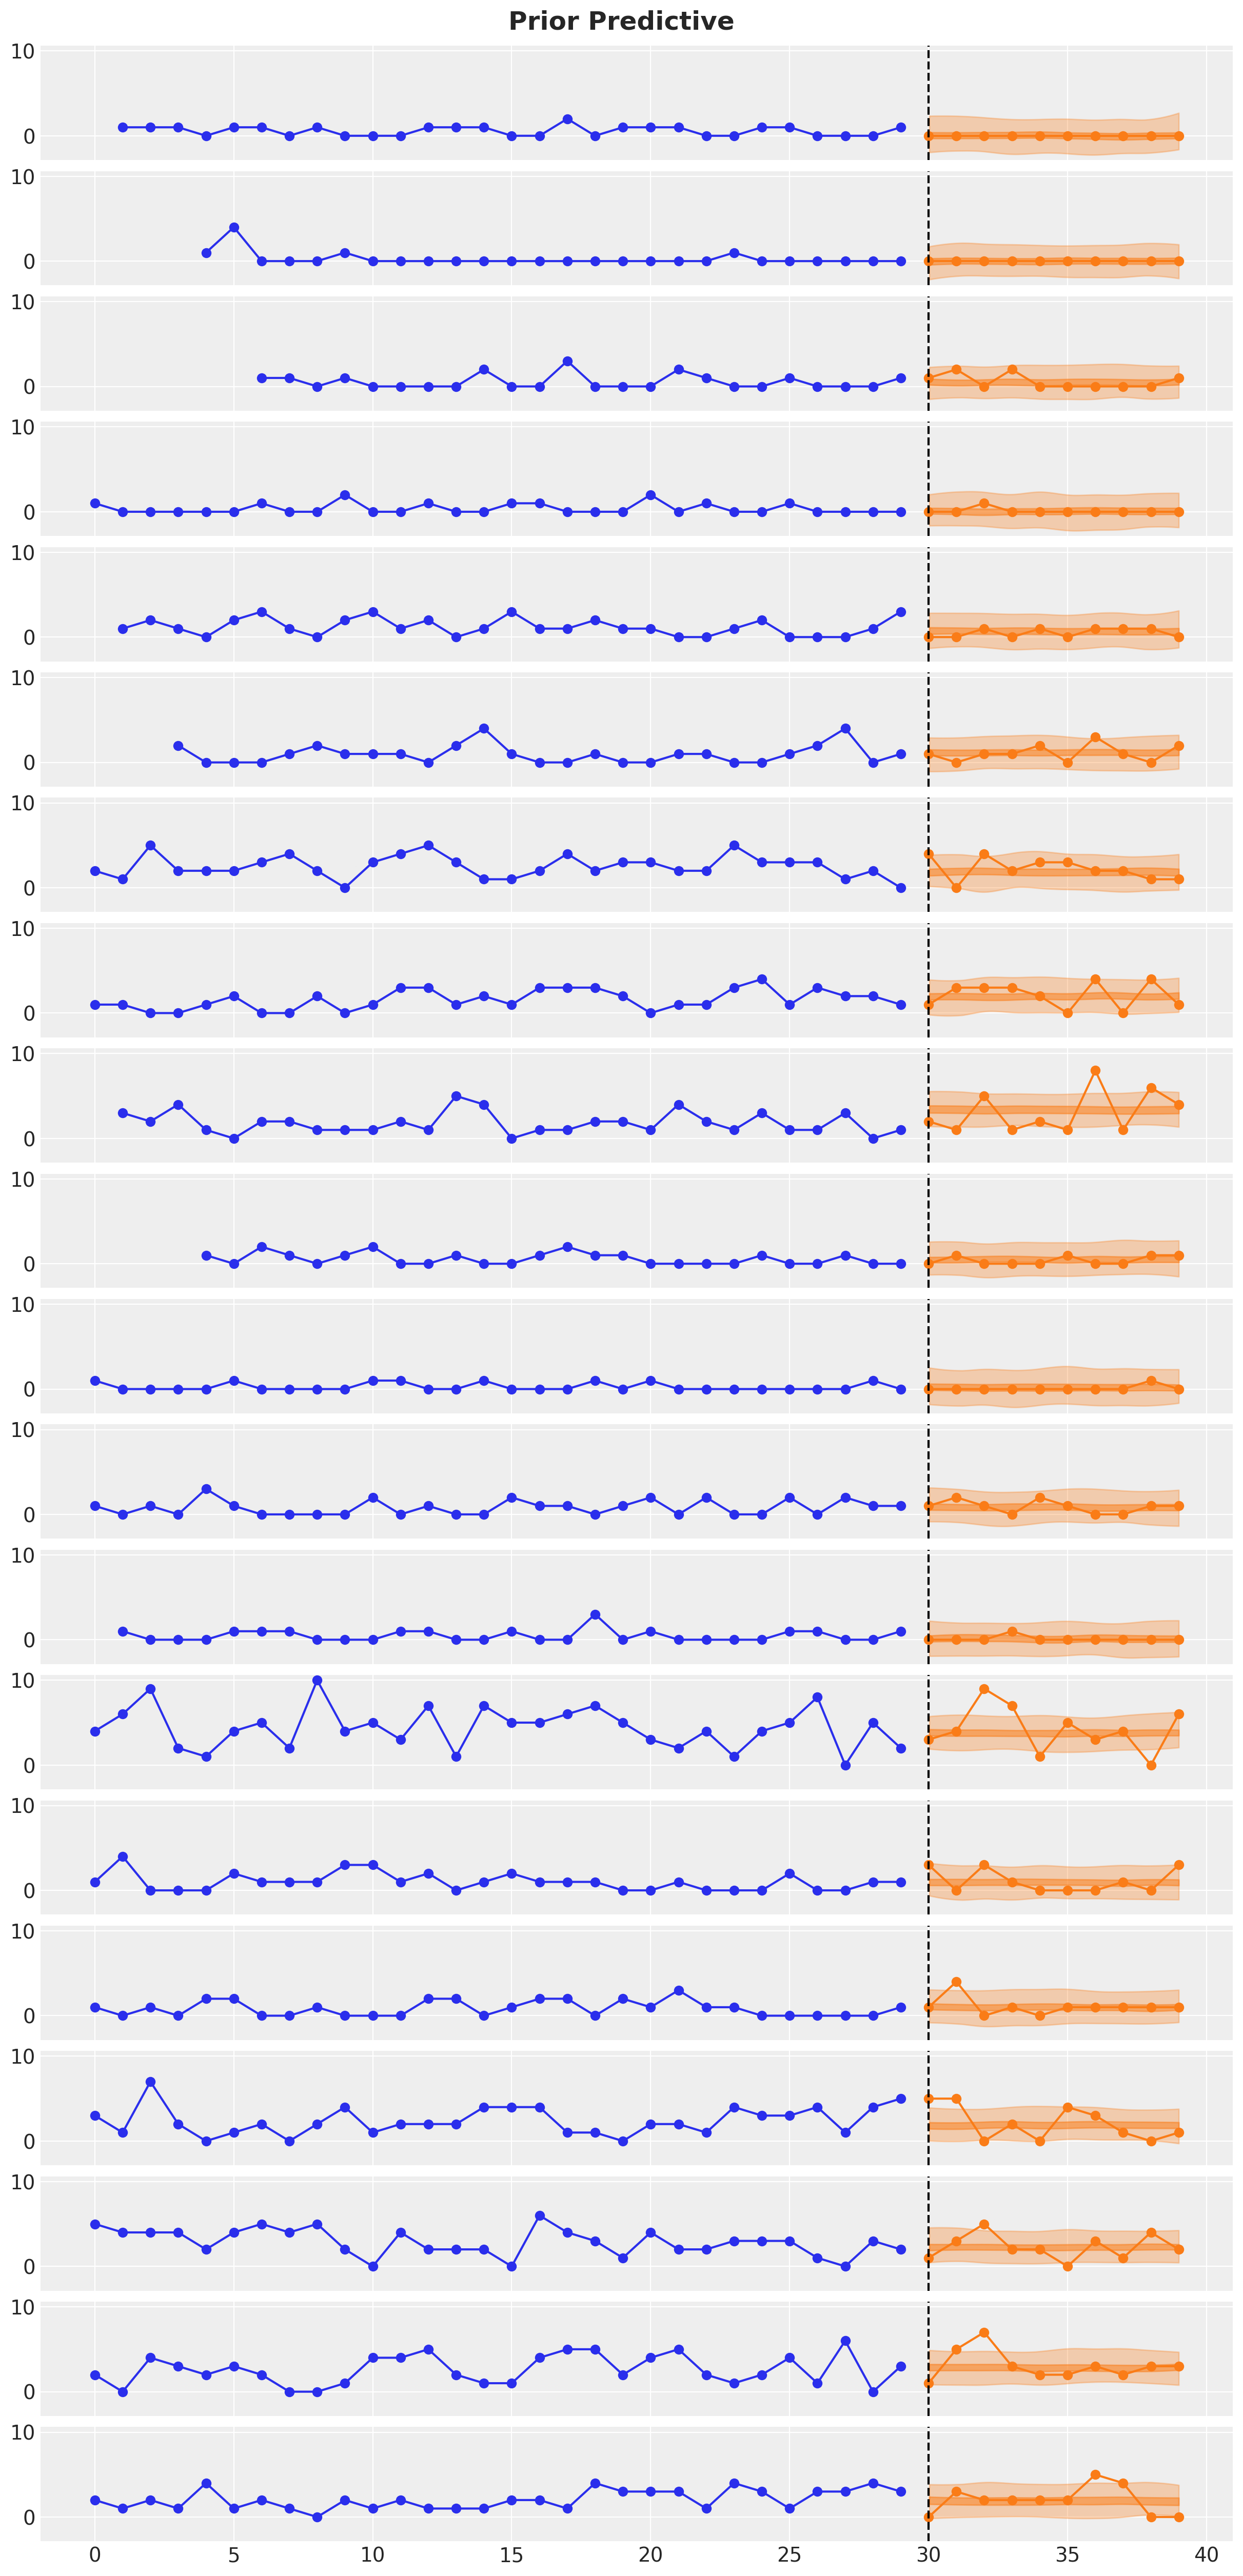

In [33]:
n_series_to_plot = 20

fig, ax = plt.subplots(
    nrows=n_series_to_plot,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(n_series_to_plot):
    az.plot_hdi(
        t_test,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3},
        ax=ax[i],
    )
    az.plot_hdi(
        t_test,
        posterior_predictive_idata["posterior_predictive"].sel(n_series=i)["forecast"],
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5},
        ax=ax[i],
    )

    ax[i].plot(t_train, counts_train_masked[:, i], marker="o", color="C0")
    ax[i].plot(t_test, counts_test[:, i], marker="o", color="C1")
    ax[i].axvline(x=t_train.shape[0], color="k", linestyle="--")

fig.suptitle("Prior Predictive", fontsize=18, fontweight="bold");